# Exercícios da Aula 11 - Detector de Haar
### Samuel Felipe dos Santos

#### Bibliotecas usadas

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean
import os

#### Funções  Reaproveitadas de Aulas Anteriores

As funções a seguir foram reaproveitadas de aulas anteriores.

Abaixo é mostrado as funções de padding, correlação, normalização e a que verifica se a coordenada de um pixel é válida.

In [3]:
#Implementação de padding com zeros utilizado pela função de correlação 
def pad(image, u,d,l,r):
    paded_image = np.zeros([image.shape[0]+u+d, image.shape[1]+l+r])
    paded_image[u:paded_image.shape[0]-d, l:paded_image.shape[1]-r] = image
    return paded_image

#Implementação da função de correlação entre uma imagem e uma máscara
def correlation(image, mask, function=np.sum):
    u = int(mask.shape[0]/2)
    d = mask.shape[0]-1-u
    l = int(mask.shape[1]/2)
    r = mask.shape[1]-1-l
    
    img_shape = image.shape
    p_image = pad(image, u, d, l, r)
    
    out = np.zeros(img_shape[:2])
    for i in range(u, u+img_shape[0]-1):
        for j in range(l, l+img_shape[1]-1):
            out[i-u,j-l] = function( mask *  p_image[ i-u :i+1+d, j-l:j+1+r ] )
    return out

#faz com que os pixels da imagem variem entre os valores de  img_min e img_max
def rescale(img, img_min, img_max):
    mn = img.min()
    mx = img.max()
    return ((img-mn)/(mx-mn)*(img_max-img_min) + img_min)

#verifica se um ponto de coordenadas [i,j] é válida para uma imagem de dimensões shape
def valid_point( shape, i,j ):
    if i>=0 and i<shape[0] and j>=0 and j<shape[1]:
        return True
    else:
        return False


### Exercício: 

**Implemente um detector de Haar para encontrar células na base de células.**

- **Dica: pense em usar a parte de dentro e fora do núcleo**

- **Use imagens da base que possuem o núcleo mais aparente**

Inicialmente foi implementada a função a seguir para calcular a integral de uma imagem, já que essa informação será necessária para o descritor de Haar.

In [4]:
def integral_image( img ):
    shape= img.shape
    integral = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            zero = False
            if i == 0:
                u = 0
                zero = True
            else:
                u = integral[i-1,j]
            if j == 0:
                l = 0
                zero = True
            else:
                l = integral[i,j-1]                
            if zero:
                lu = 0
            else:
                lu = integral[i-1,j-1]
            integral[i,j] = img[i,j] + l+u-lu
    return integral

Uma vez que se tem a integral da imagem calculada, a função a seguir é capaz de retornar a área (soma da intensidades dos pixels) de uma região retangular da imagem.

A região retangular é definida por dois pontos, o ponto superior esquerdo e o ponto inferior direito.
Portanto, sendo o ponto 1 $(x1,y1)$ e o ponto 2 $(x2,y2)$, os quatro pontos que delimitam o retangulo serão $(x1,y1)$, $(x1,y2)$, $(x2,y1)$ e $(x2,y2)$. 

In [5]:
def get_region_area(integral, point1, point2):
    (p1x, p1y) = point1
    (p2x, p2y) = point2
    shape = integral.shape
    zero = False
    if p1x == 0:
        u = 0
        zero = True
    else:
        u = integral[p1x-1,p2y]
    if p1y == 0:
        l = 0
        zero = True
    else:
        l = integral[p2x,p1y-1]
    if zero:
        lu = 0
    else:
        lu = integral[p1x-1,p1y-1]
    return integral[p2x,p2y]-u-l+lu

A seguir o funcionamento do calculo da imagem integral e sua utilização para calcular a área de regiões retangulares da imagem é testado, sendo usado um dos exemplos simples apresentados em aula.

Como pode ser visto, o algoritmo esta funcionando corretamente.

In [6]:
test_img = np.array([[1,2,2,4,1],
                     [3,4,1,5,2],
                     [2,3,3,2,4],
                     [4,1,5,4,6],
                     [6,3,2,1,3]])
integral_img = integral_image( test_img )
print('imagem:')
print(test_img)
print('\nimagem integral')
print(integral_img)
area = get_region_area(integral_img, [2,2], [3,3])
print('\nárea da região x=[2,3], y=[2,3]:', area)

imagem:
[[1 2 2 4 1]
 [3 4 1 5 2]
 [2 3 3 2 4]
 [4 1 5 4 6]
 [6 3 2 1 3]]

imagem integral
[[ 1.  3.  5.  9. 10.]
 [ 4. 10. 13. 22. 25.]
 [ 6. 15. 21. 32. 39.]
 [10. 20. 31. 46. 59.]
 [16. 29. 42. 58. 74.]]

área da região x=[2,3], y=[2,3]: 14.0


Foi implementado então o detector de Haar, como pode ser visto no código a seguir.

Ele tem os seguintes parâmetros relevantes que podem ser destacados:

- **$img$:** Imagem sobre a qual o detector pe aplicado;
- **$boxes$:** Uma lista de par de pontos que definem caixas, ou regiões retangulares.

Dado o par de pontos $[ (x1,y1),(x2,y2) ] \in boxes$, a região retangular definida por esses pontos será deslizada pela imagem toda, de acordo com a seguinte equação para definir os dois pontos que delimitam a região retangular para cada pixel da imagem:

$ [ (i+x1, j+y1), (i+x2, j+y2) ]$  para  $i \in linhas$  e  $j\in colunas$

- **$boxes\_size:$** Quantidade de pixels na região retangular, usado para calcular a média da intensidade dos pixels da caixa a partir da área obtida com a imagem integral;

- **$values$:** É uma lista de valores pelo os quais a área de cada caixa é multiplicada.
O algoritmo atribui um valor para cada pixel de acordo com a equação a seguir

$h(i,j) = \sum_{k=0}^{n\ caixas} media\_caixa_k \times value_k$

Dessa forma, se é desejado enibir intensidades altas em uma caixa, se atribui valores negativos para o $value$ correspondente, e caso queira encontrar intensidade altas na caixa, se atribui valores positivos para o $value$ correspondente.

Para encontrar o local com os objetos procurados, procura-se os pixels de maior instensidade na saído do detector de Haar.

- **overlap:** Lista com o mesmo tamanho da quantidade de caixas, cada elemento $overlap_i=k$ indica que a caixa $k$ esta sobreposta a caixa $i$.
Quando isso ocorre, a área da caixa $k$ é subtraida da área da caixa $i$.
A quantidade de pixels da caixa $i$ deve levar isso em consideração, não contando os pixels que estão sobrepostos. 
A implementação só permite que $k<i$, caso contrario nada é feito.
Essa ferramenta permite que sejam definidas caixas mais facilmente.

In [18]:
class haar:
    def __init__(self, boxes, boxes_size, values, overlap=None, img = None):
        self.boxes = boxes
        self.values = values
        self.boxes_size = boxes_size
        self.box_shape = [0,0]
        if overlap is None:
            self.overlap = np.full( len(boxes), np.inf )
        else:
            self.overlap = overlap

        for [[xi,yi],[xf,yf]] in self.boxes:
            shape = [xf-xi, yf-yi]
            for i in range(2):
                if self.box_shape[i] < shape[i]:
                    self.box_shape[i] = shape[i]

        if img is not None:
            self.integral = integral_image(img)
            self.shape = self.integral.shape        
            self.calc_limits()
        else:
            self.integral = None

    def calc_limits( self ):
        self.u = int(self.box_shape[0]/2)
        self.d = self.box_shape[0]-self.u
        self.l = int(self.box_shape[1]/2)
        self.r = self.box_shape[1]-self.l

    def run( self, img=None ):
        if img is not None:
            self.integral = integral_image(img)
            self.shape = self.integral.shape        
            self.calc_limits()
        elif self.Integral is None:
            return
        out = np.zeros(self.shape)
        for i in range(self.u, self.shape[0]-self.d):
            for j in range(self.l, self.shape[1]-self.r):
                areas = []
                for k in range(len(self.boxes)):
                    [[xi,yi],[xf,yf]] = self.boxes[k]
                    area = self.values[k]*get_region_area(self.integral, [i+xi, j+yi], [i+xf, j+yf])
                    if self.overlap[k] < k:
                        area -= areas[self.overlap[k]]
                    areas+= [area]
                for k in range(len(self.boxes)):
                    out[i,j] += self.values[k] * (areas[k]/self.boxes_size[k])
                        
        return out      

A seguir são mostradas as imagens sobre as quais o detector de Haar foi aplicado.
Elas pertencem a um conjunto de dados de células disponivel em http://www.cellimagelibrary.org/images/45758.

Foram escolhidas as imagens de células que eram grandes e possuiam um núcleo aparente.

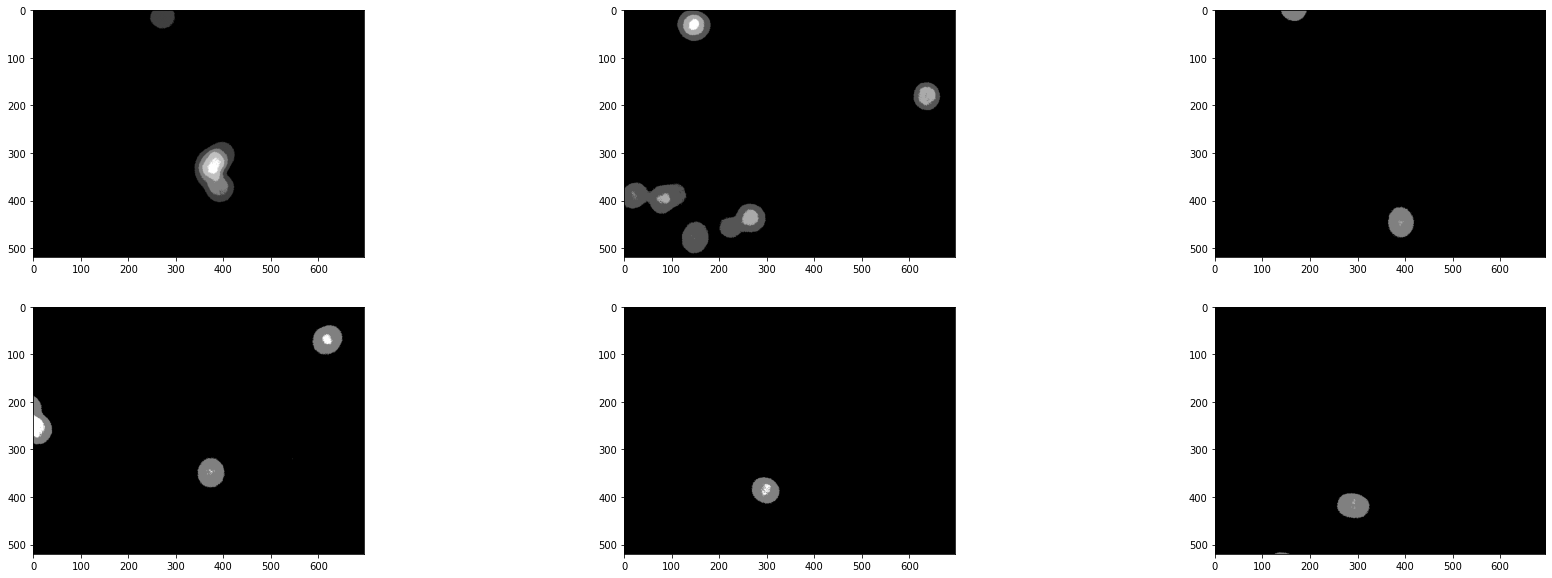

In [8]:
path = 'data/aula11/cells'
files = os.listdir( path )
imgs = []
fig = plt.figure(figsize=(30, 10))

for i,file in enumerate(files):
    img = rescale(cv.imread(os.path.join(path,file), 0), 0,1)
    imgs += [img]
    fig.add_subplot(2, 3, i+1)
    plt.imshow(img, cmap='gray')

Para aplicação do detector de Haar, são usadas duas caixas, ambas com o mesmo centro, a menor recebe um valor de $value$ positivo pois é esperado detectar o núcleo com ela, que é mais claro que o restante da célula.
A segunda caixa é maior, e tem $value$ negativo para inibir regiões mais claras, já que o restante da célula costuma ter intensidade um pouco menor que o núcleo.

Foram testados caixas quadradas com três tamanhos para a menor e três para a caixa maior, sendo o tamanho definido pela distância do centro até um dos lados da caixa

-Tamanhos das caixa menores: 5, 10, 15;

-Tamanhos das caixa maiores: 20, 25, 30.

A seguir pode ser visto ilustações de cada uma das combinações de tamanhos de caixas, e a maneira como elas são sobrepostas.

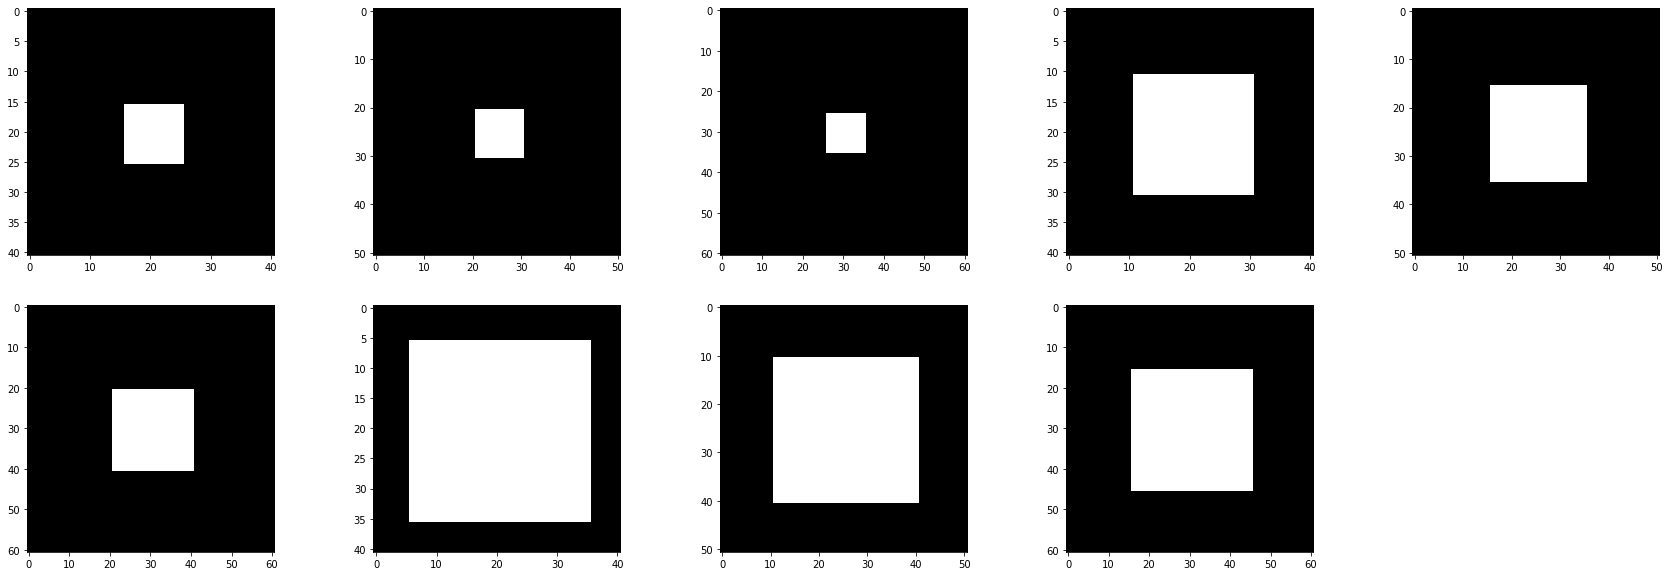

In [9]:
fig = plt.figure(figsize=(30, 10))
i=1
for size1 in [5,10,15]:
    for size2 in [20, 25, 30]:
        box = np.zeros([2*size2+1, 2*size2+1])
        for j in range(-size1,size1):
            for k in range(-size1,size1):
                box[size2-j, size2-k] = 1
        
        fig.add_subplot(2, 5, i)
        plt.imshow(box, cmap='gray')
        i+=1

A seguir o detector de Haar é aplicado, resultando em imagens onde pixels mais claros tem maior chance de serem o centro de uma célula.

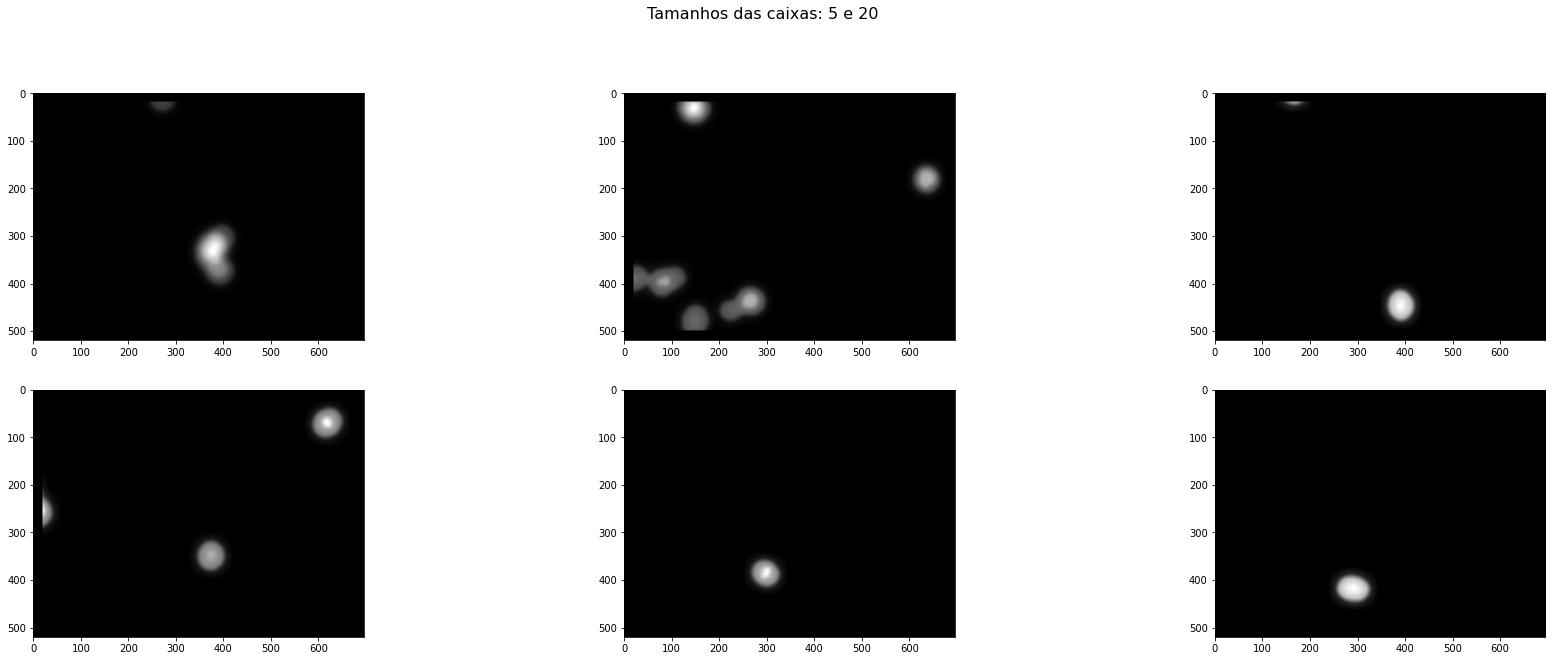

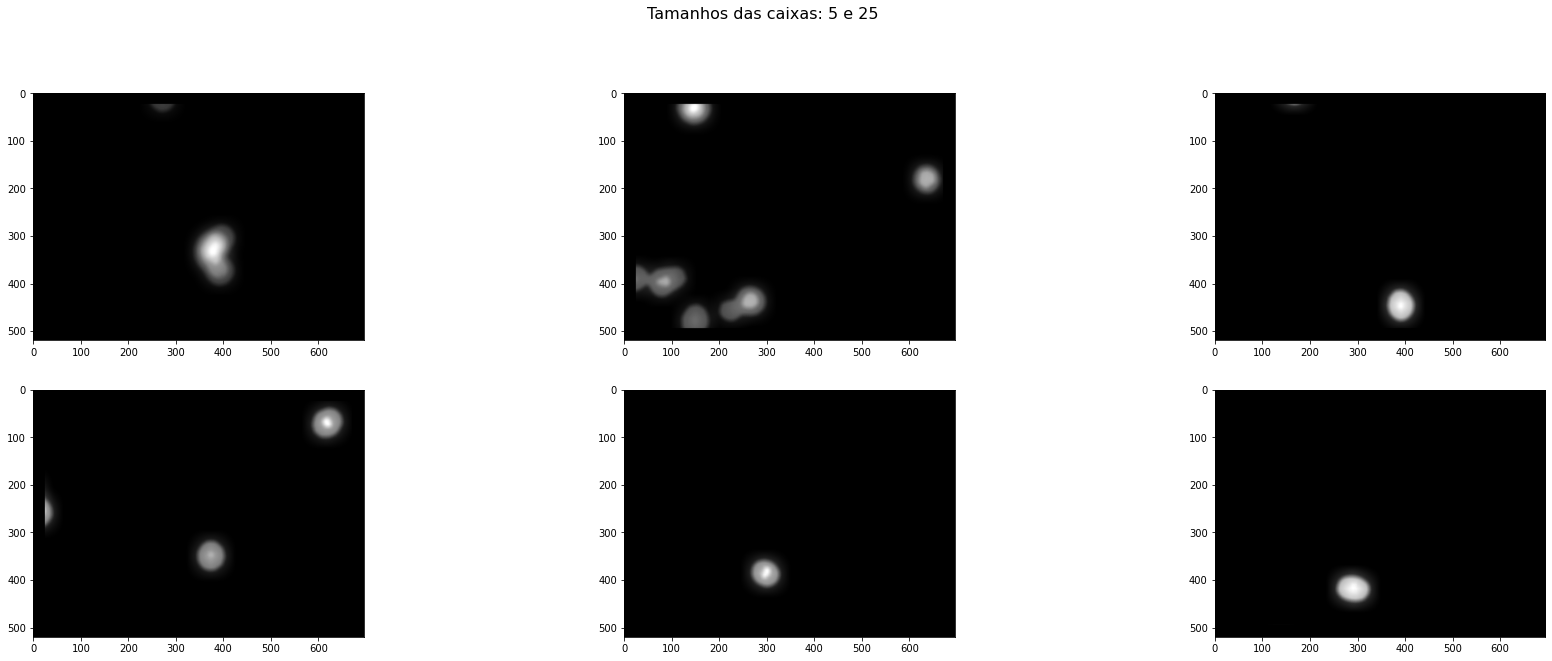

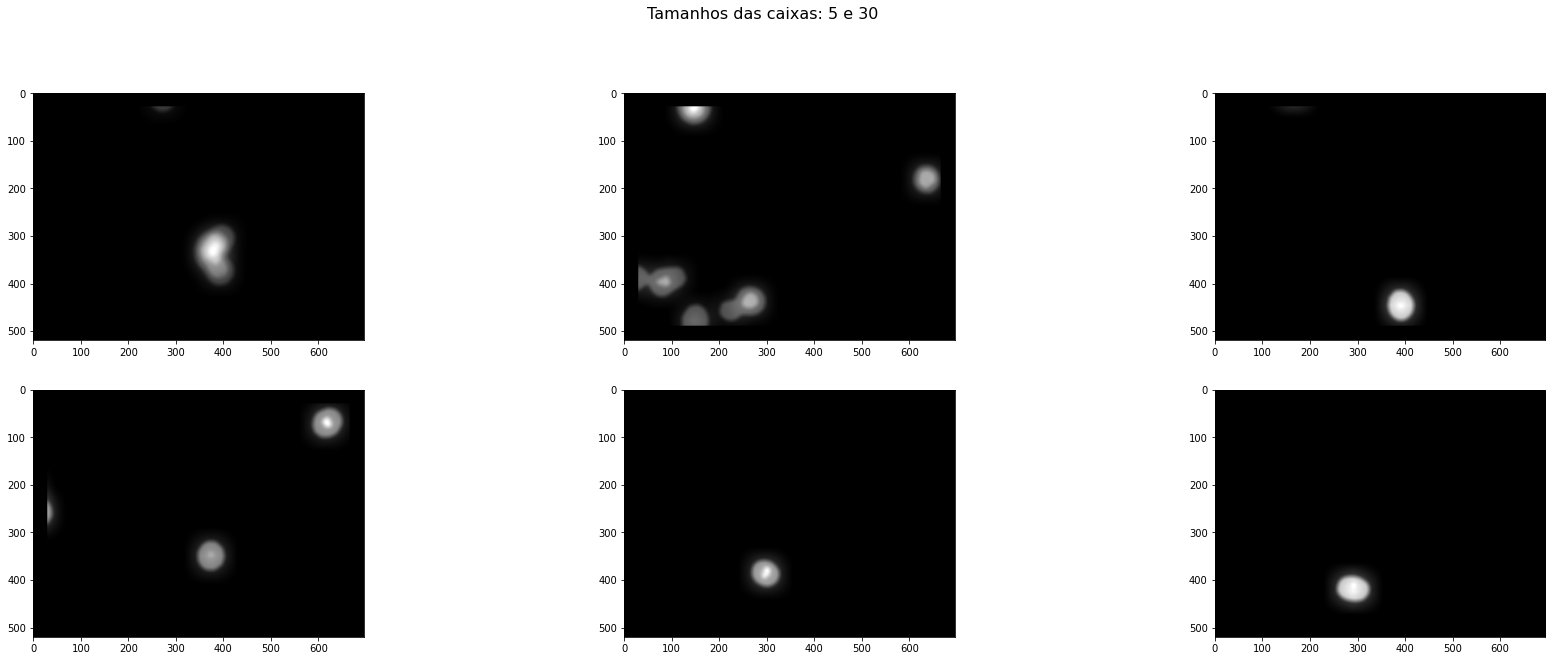

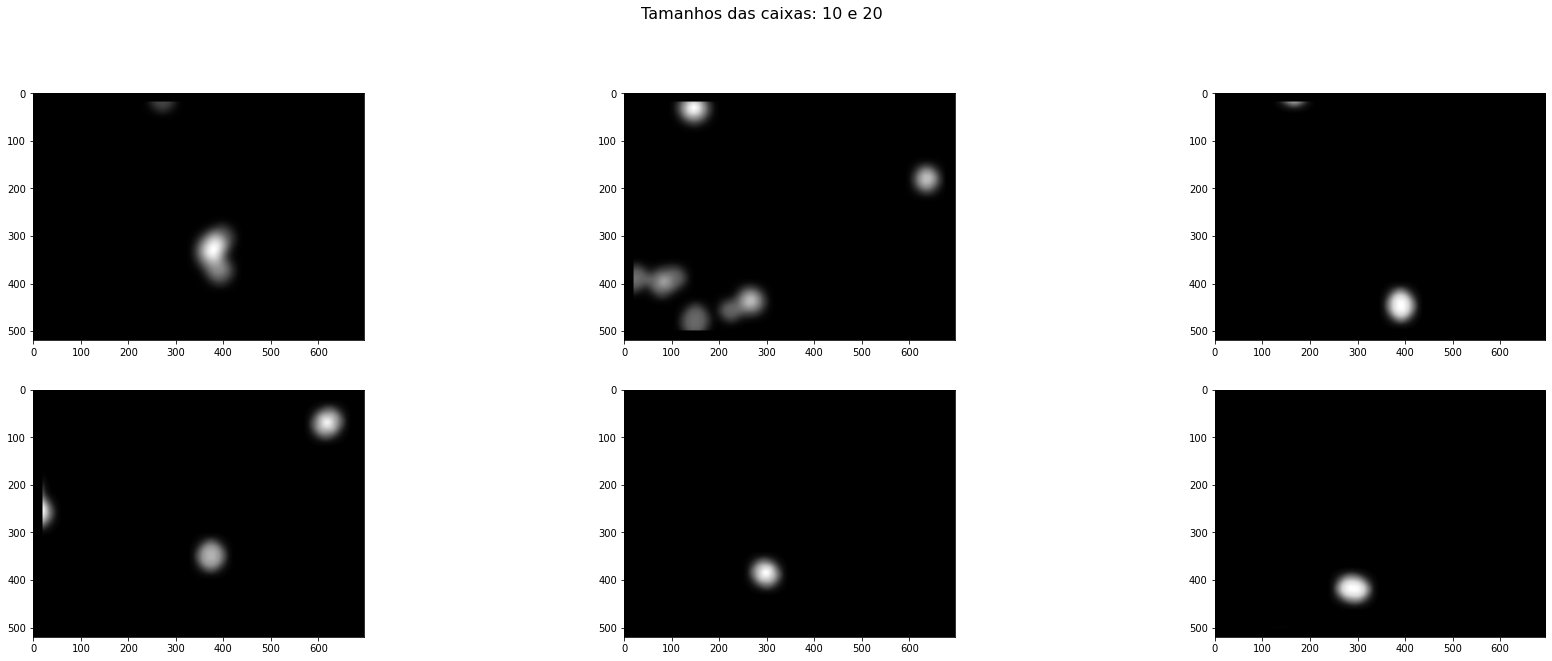

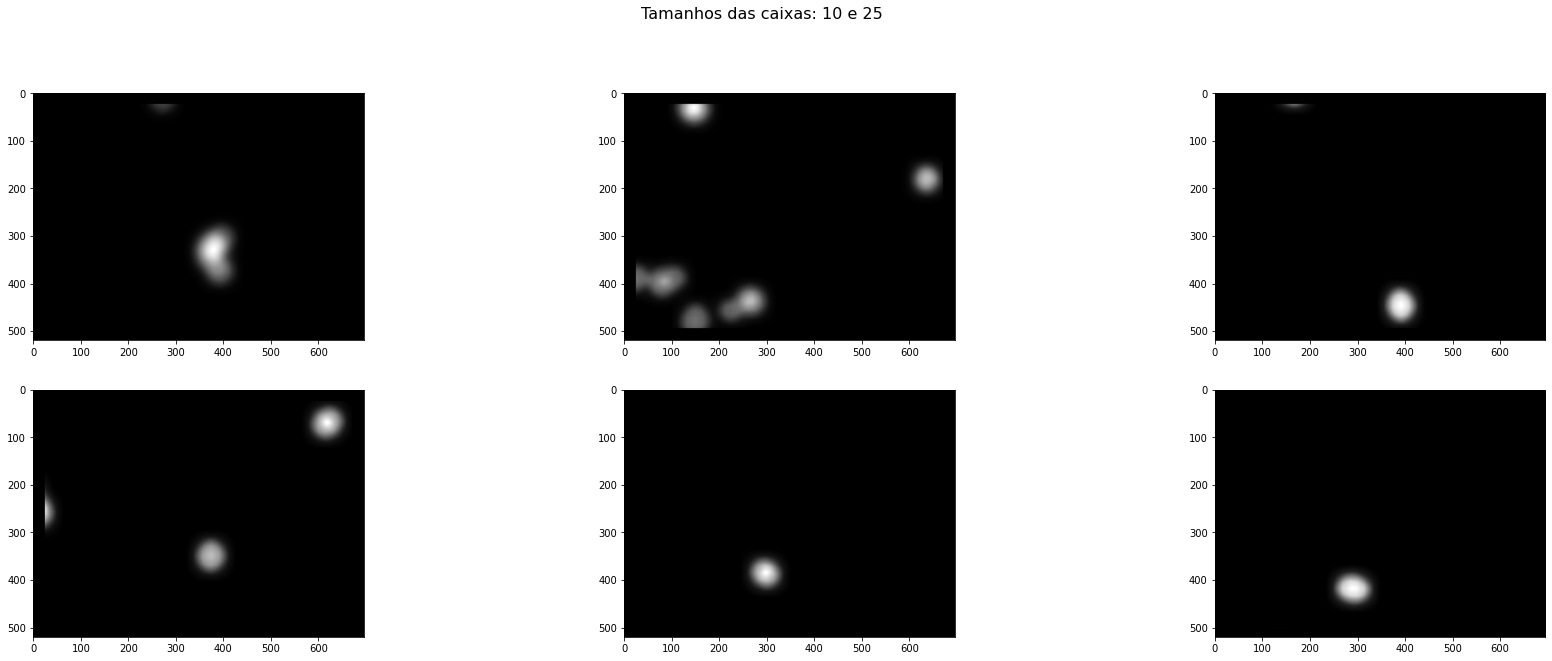

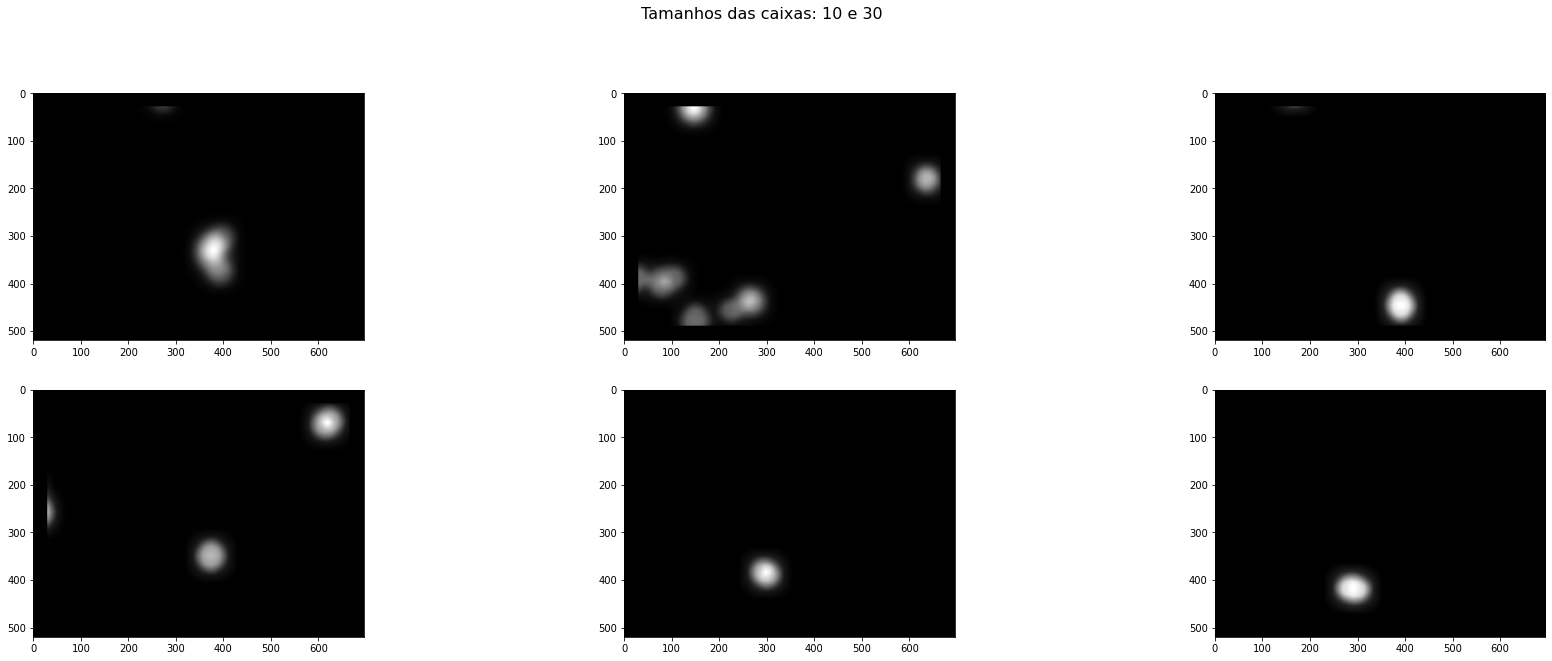

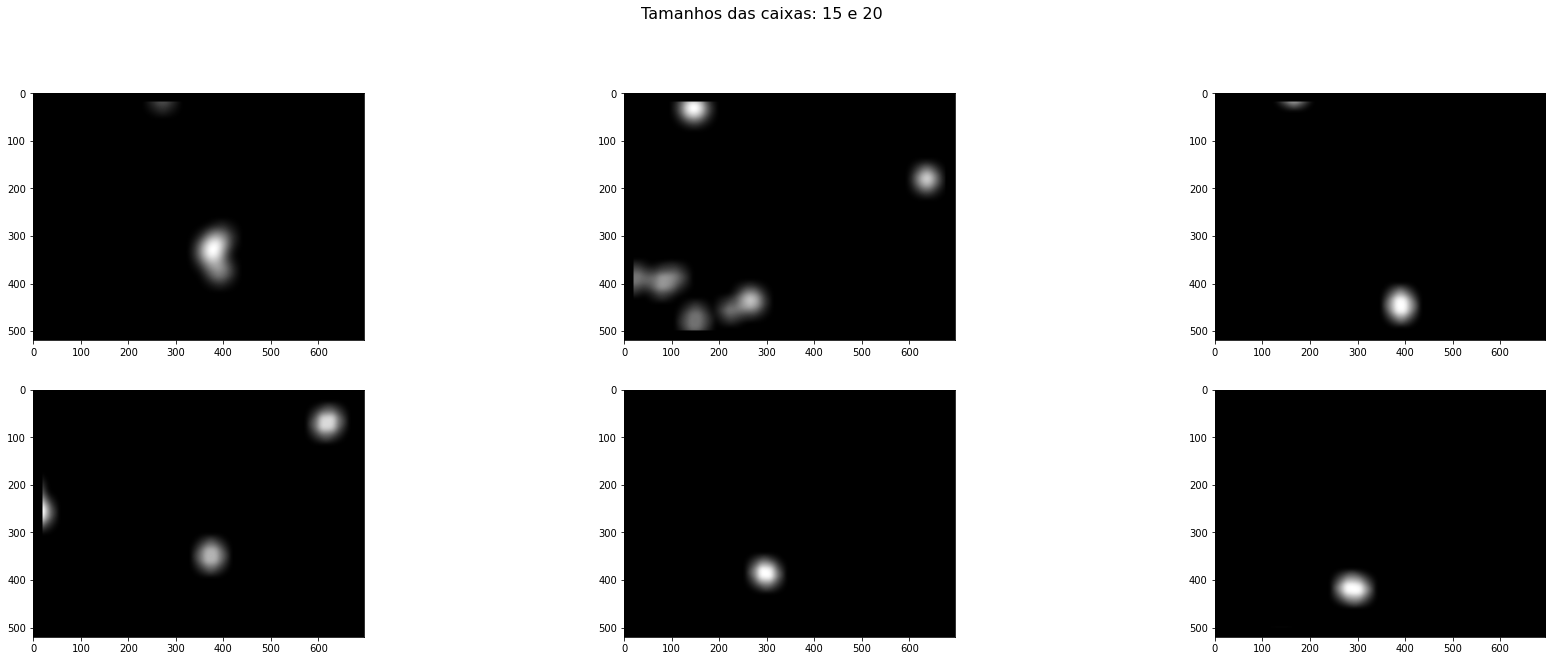

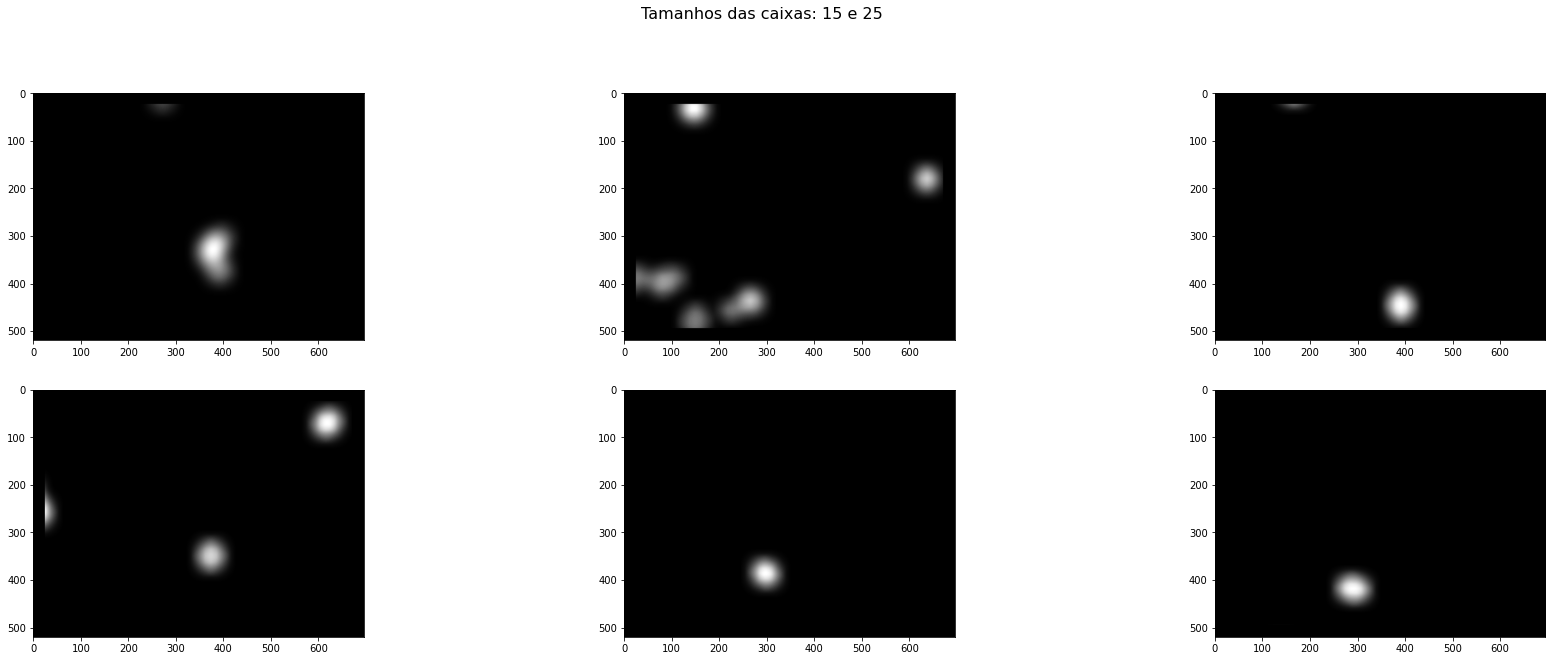

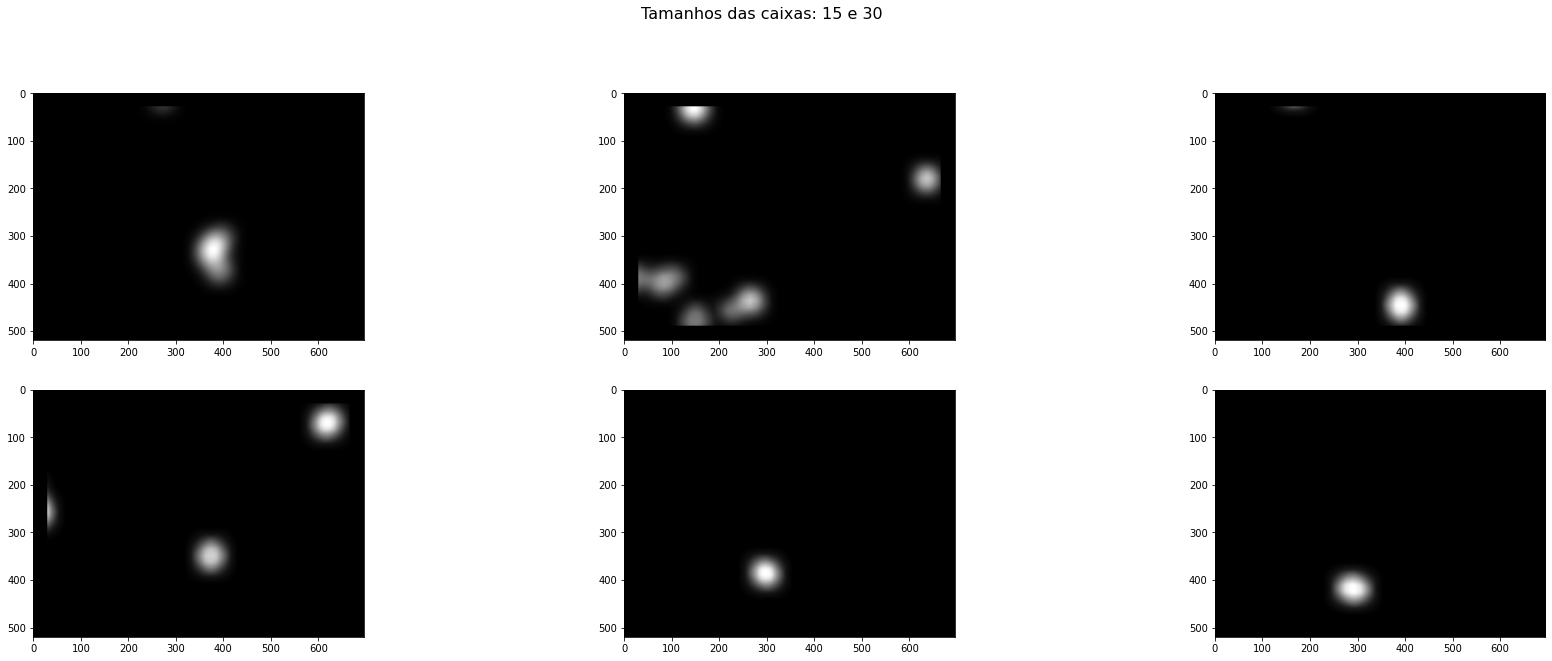

In [19]:
haar_imgs = []
for size1 in [5,10,15]:
    for size2 in [20, 25, 30]:

        boxes = np.array([ [[-size1,-size1],[size1,size1]],         
                           [[-size2,-size2],[size2,size2]] ])
        
        boxes_size = [(2*size1+1)**2, (2*size2+1)**2 - (2*size1+1)**2 ]
        values = [1,-1]
        overlap = [0,0]
        hd = haar(boxes, boxes_size, values, overlap)

        fig = plt.figure(figsize=(30, 10))
        fig.suptitle('Tamanhos das caixas: '+str(size1)+' e '+str(size2), y=1, fontsize=16)
        himgs = []
        for i,img in enumerate(imgs):

            himg = hd.run( img )
            himgs += [himg]

            fig.add_subplot(2, 3, i+1)
            plt.imshow(himg, cmap='gray')
        haar_imgs += [himgs]

A partir do resultado do dectector de Haar, a função $find\_highest$, cuja a implementação pode ser vista a seguir, procura os pontos com intensidade mais alta a partir de um determinado limiar, e caso mais de um ponto de alta intensidade seja encontrada em uma região proxima (tamanho do raio da célula), apenas o mais alto é armazenado. É esperado que esses pontos sejam o centro das células.

A função $highlight\_points$, também implementada a seguir, dado esses pontos, destaca na imagem quadrados ao redor deles, onde se espera que a célula esteja.

In [43]:
def find_highest(img, threshold, size):
    shape = img.shape
    high_points = []
    highest_points = []
    high_img = np.zeros( img.shape )
    for i in range(shape[0]):
        for j in range(shape[1]):
            if img[i,j] > threshold:
                high_img[i,j] = img[i,j]
                high_points += [[i,j]]
    
    for [i,j] in high_points:
        highest = True
        for x in range(-size[0],size[0]):
            for y in range(-size[1],size[1]):
                if valid_point(shape, x+i, y+j) and high_img[x+i, y+j]>high_img[i, j]:
                    highest = False
        if highest:
            highest_points += [[i,j]]
    return highest_points

def highlight_points(points, shape, size):
    out = np.zeros(shape, dtype='uint8')
    for [x,y] in points:
        for i in range(-size[0],size[0]):
            for j in range(-size[1],size[1]):
                if valid_point(shape, x+i, y+j):
                    out[x+i, y+j] = 1
    return out

Abaixo é mostrado as regiões onde se espera encontrar as células para os diferntes tamanhos de caixa, sendo essas regiões destacadas em verde.
No geral, vários tamanhos de caixa obtiveram bons resultados.
Os melhores desempenho foi obtido quando se usou o tamanho da caixa pequena como 10 e o tamanho da caixa grande 30.
Acredito que isso tenha ocorrido por tererm dimensões proximas as das células buscadas.

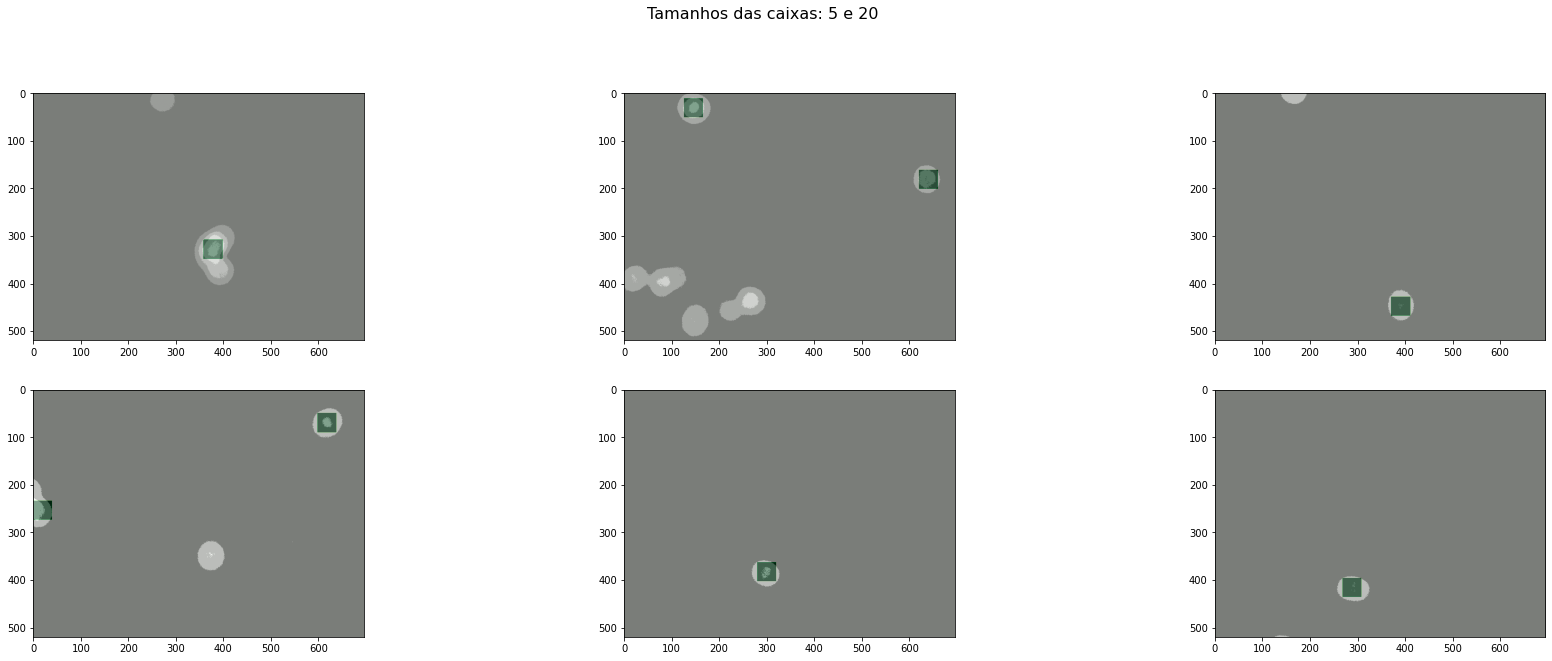

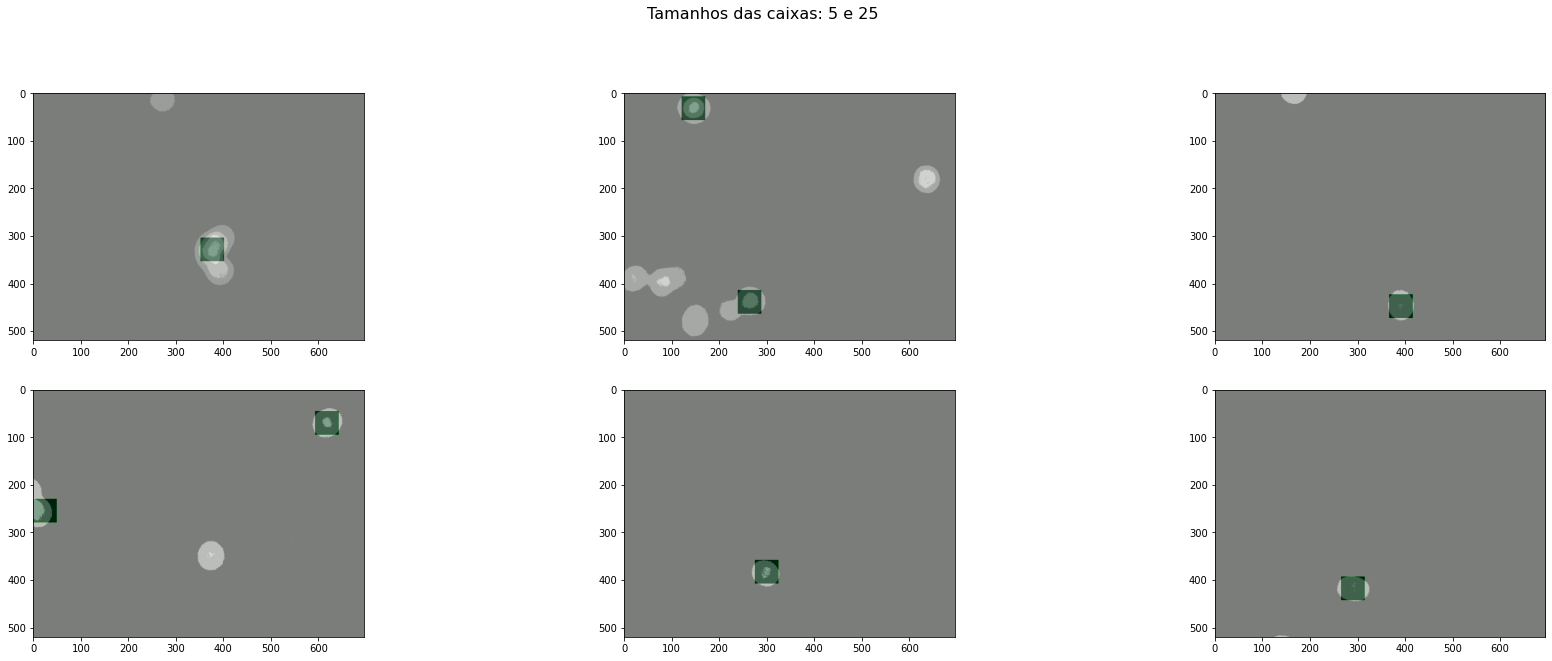

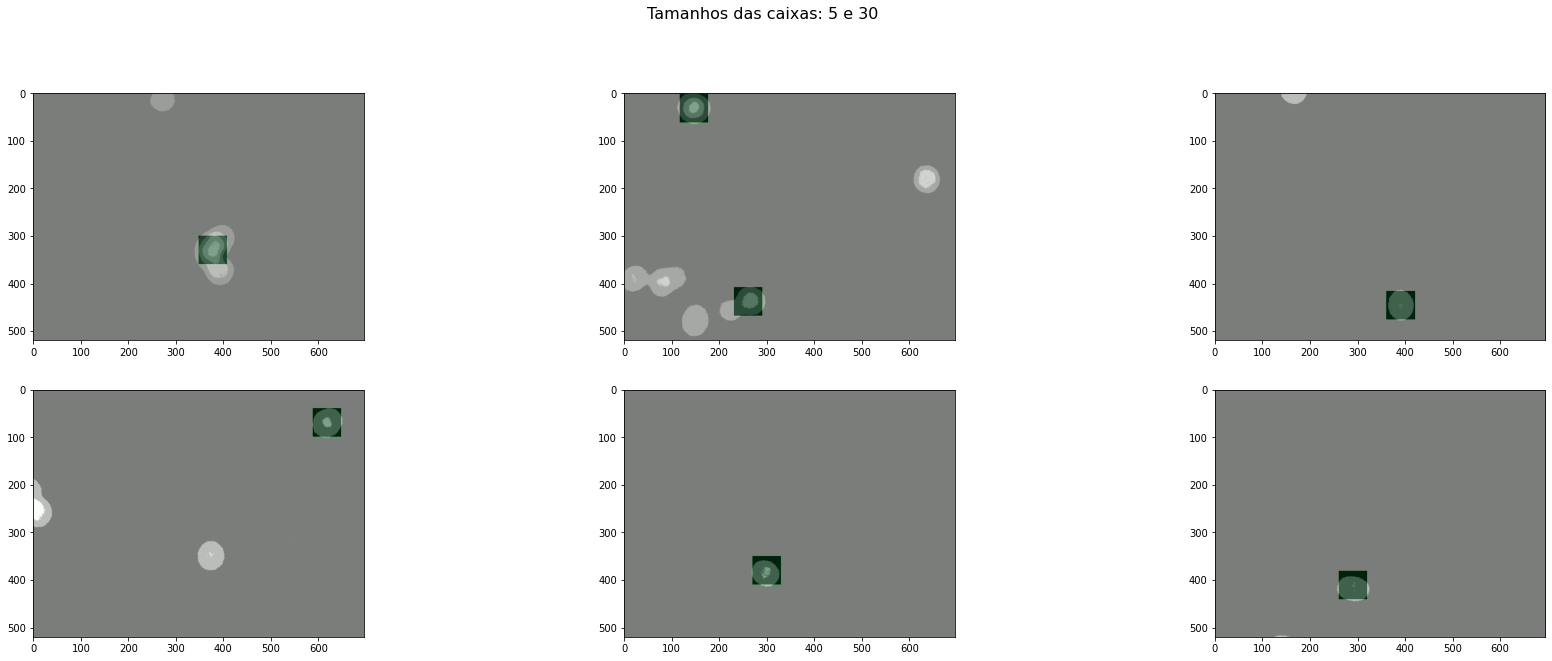

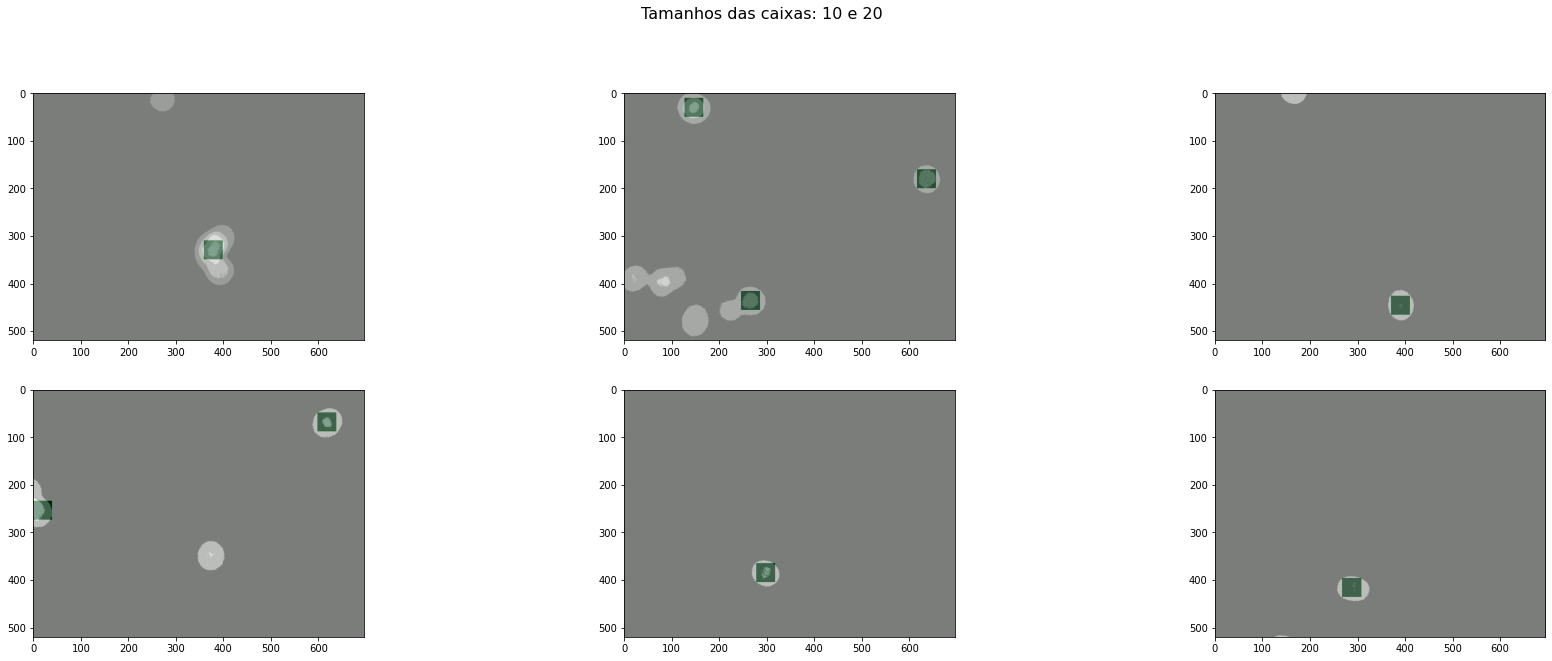

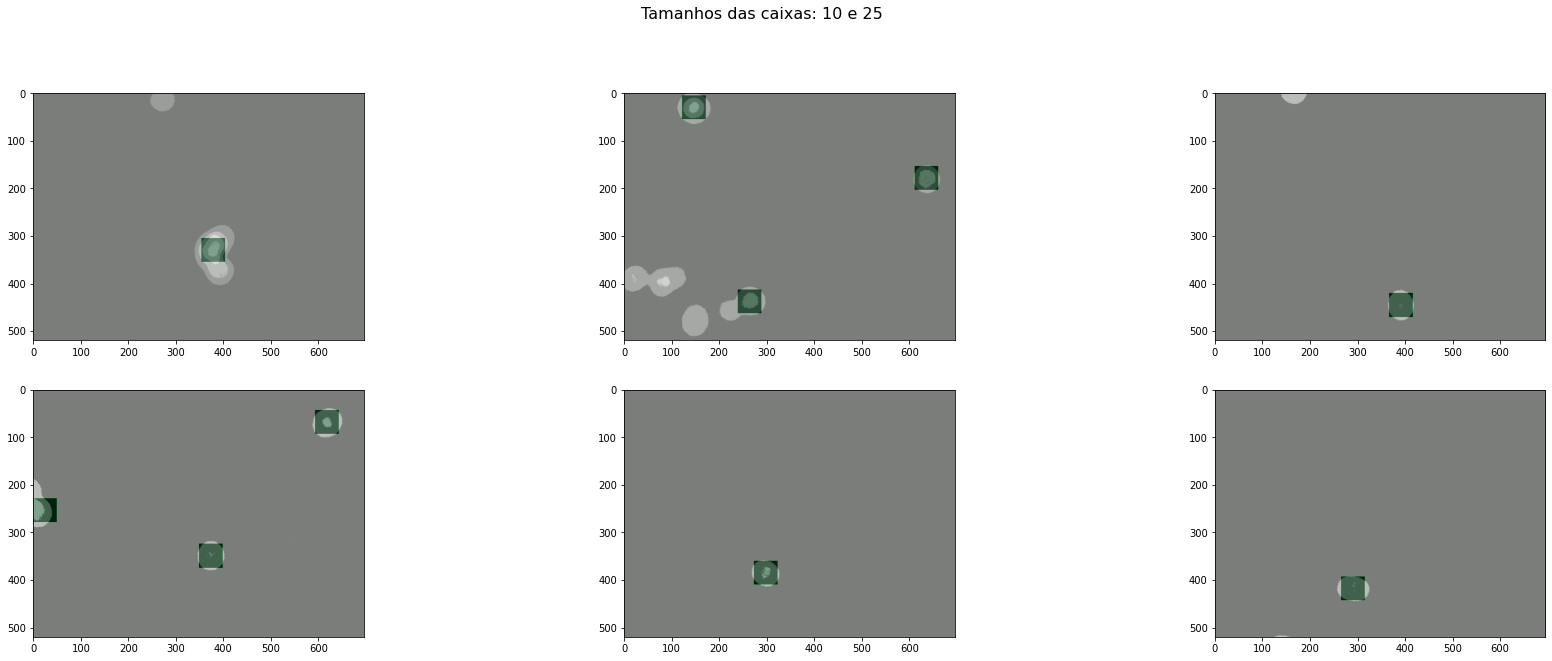

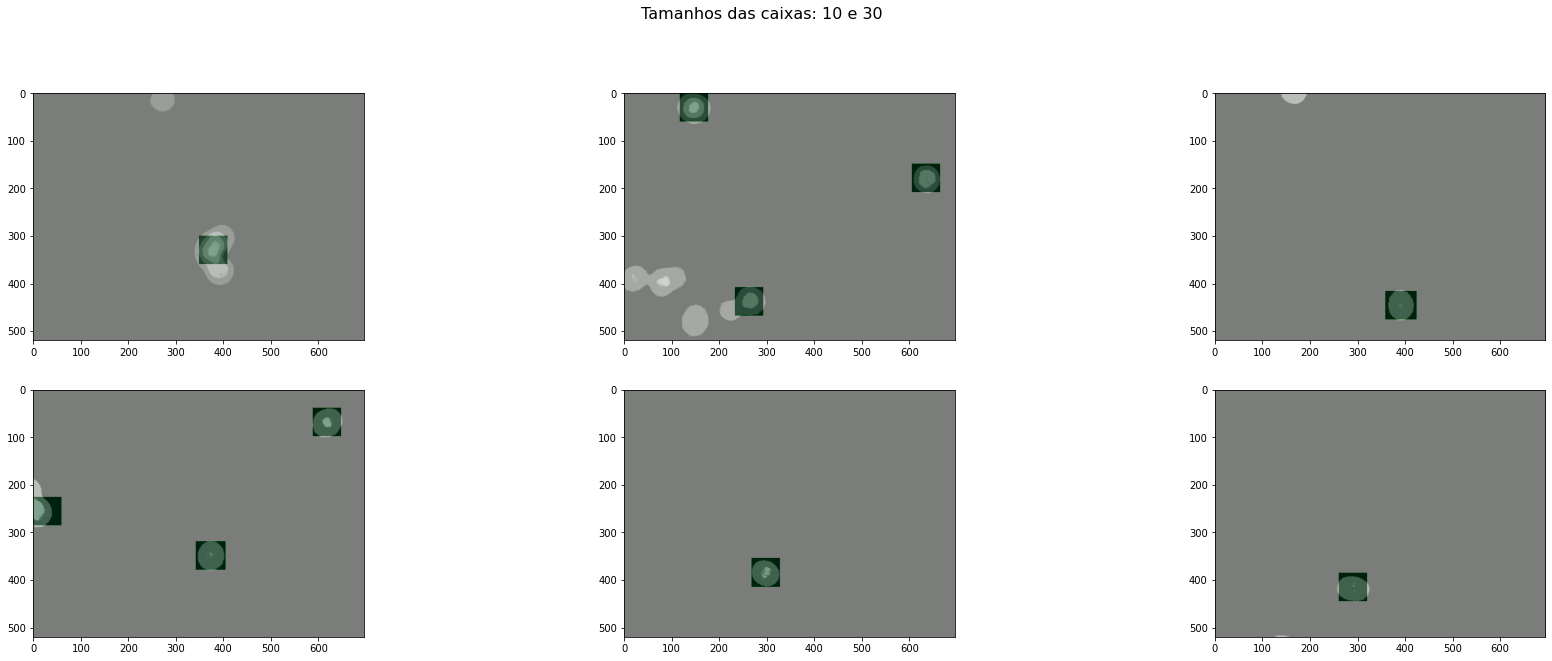

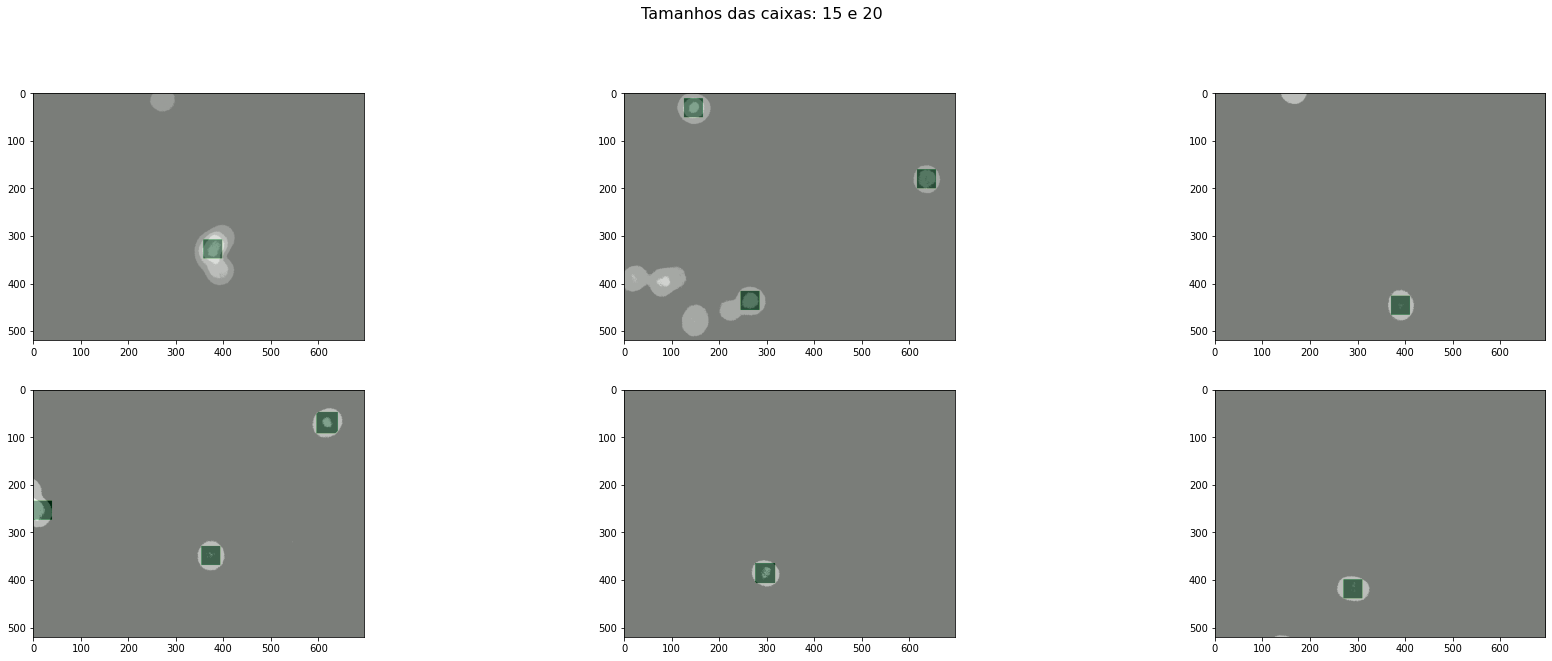

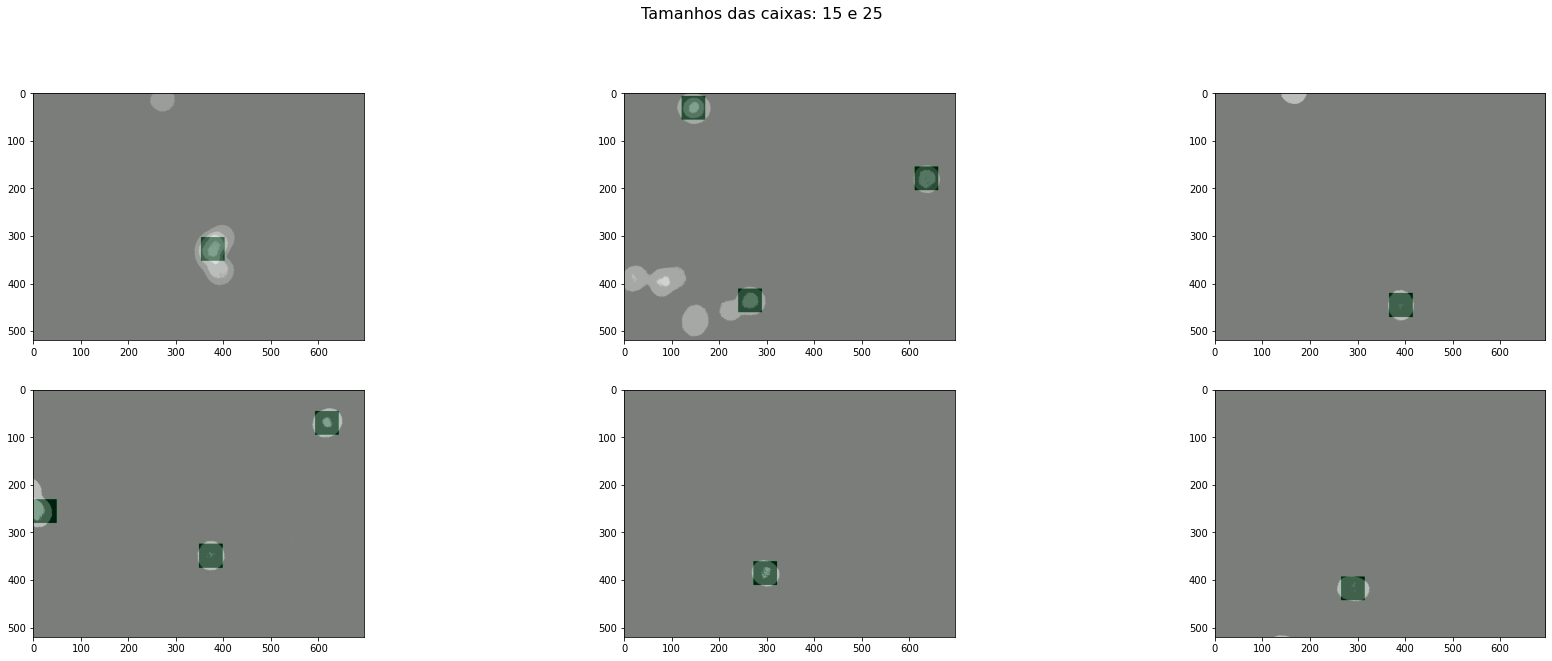

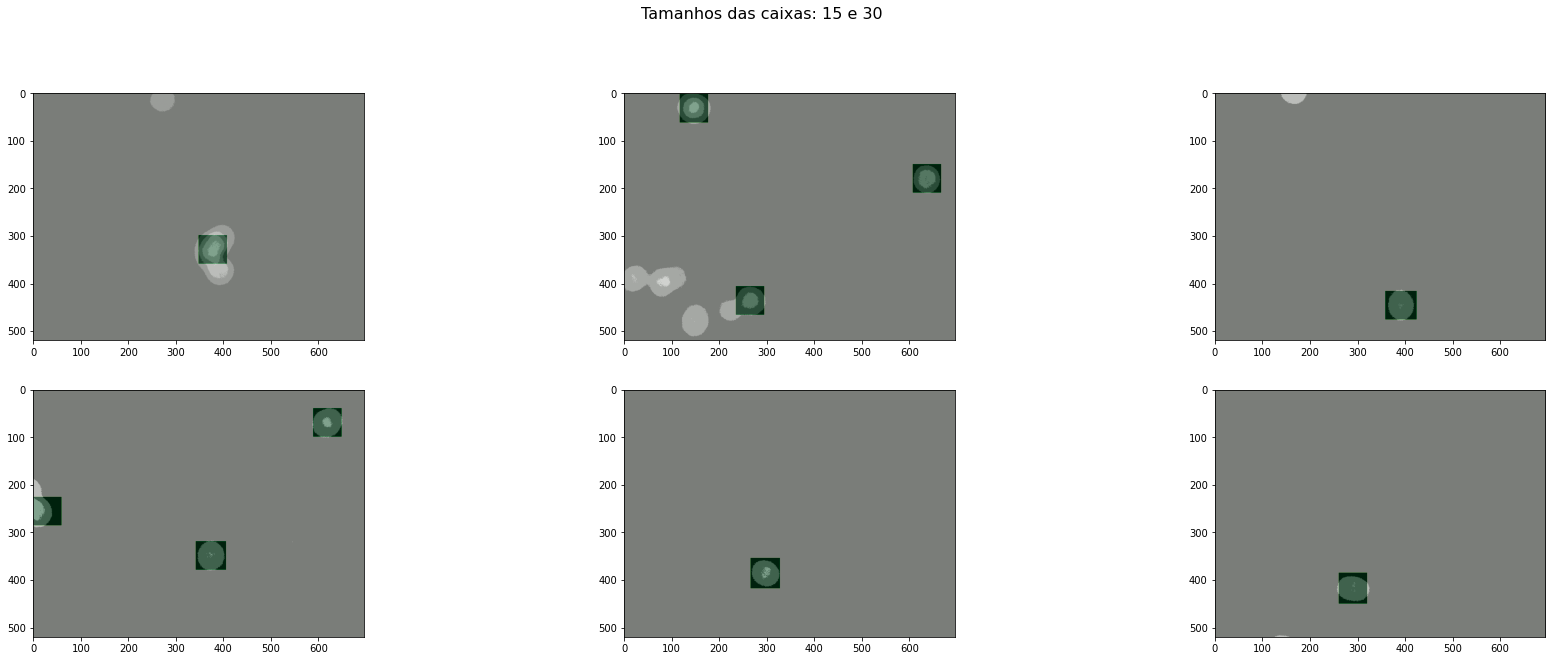

In [47]:
i=0
for size1 in [5,10,15]:
    for size2 in [20, 25, 30]:
        fig = plt.figure(figsize=(30, 10))
        fig.suptitle('Tamanhos das caixas: '+str(size1)+' e '+str(size2), y=1, fontsize=16)
        for j,img in enumerate(haar_imgs[i]):

            points = find_highest(img, img.max()*0.7, [size2,size2] )
            h = highlight_points(points, img.shape, size=[size2,size2])

            fig.add_subplot(2, 3, j+1)
            plt.imshow(imgs[j], cmap='gray')
            plt.imshow(h , cmap='Greens', vmin=0, vmax=1, alpha=0.5)
        i+=1

Por fim, a seguir é mostrado apenas o resultado da melhor configuração de tamanhos de caixa encontrada, 10 para a pequena e 30 para a grande, sendo a que foi capaz de encontrar mais células.

Como pode ser visto, foram obtidos resultados muito bons sendo a maioria das células encontradas pelo método, de forma que o centro da caixa fosse o nécleo da célula (isso só não ocorreu na célula que que não aparecia por inteiro na imagem).

Todas as células que possuiam o núcleo mais aparente (com intensidade consideravelmente mais alta), foram detectadas.
Apenas células que não possuiam núcleo, ou cujo o núcleo não possuia intensidade tão alta, não foram detectadas.

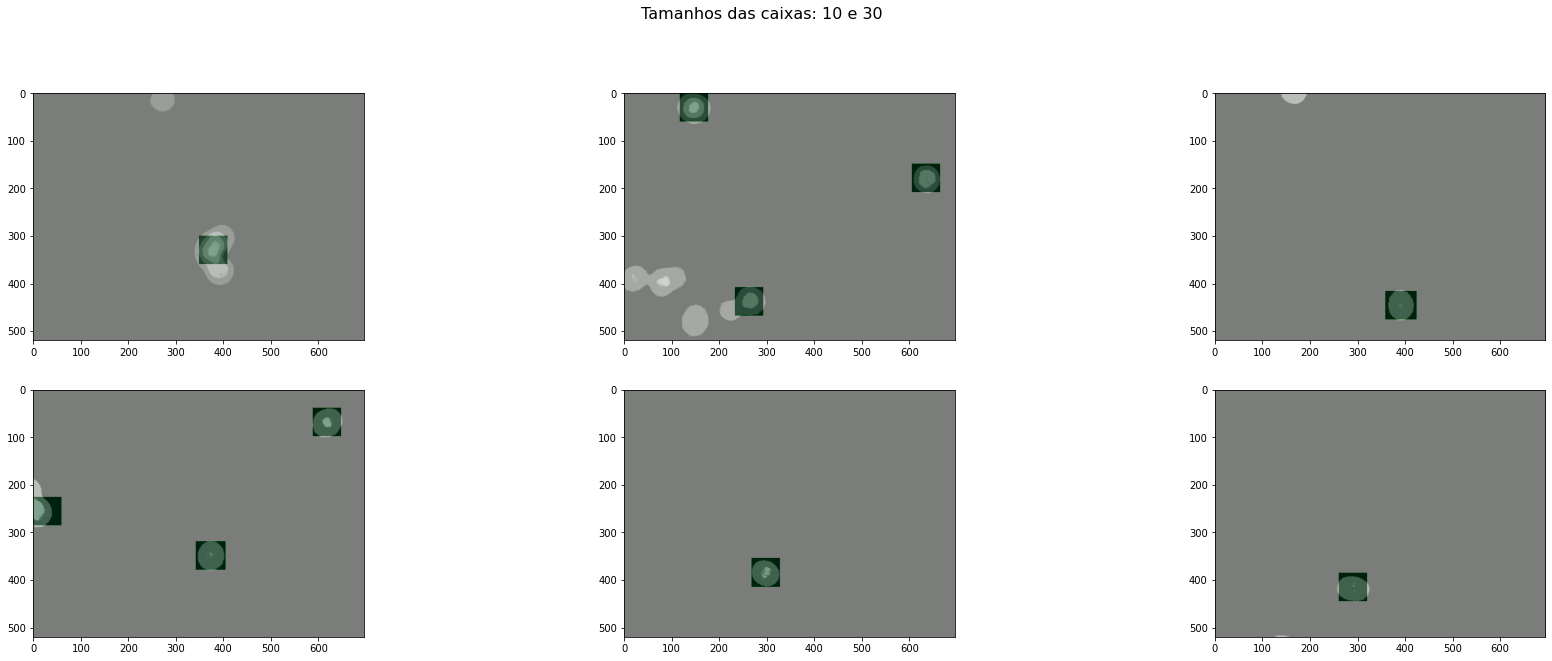

In [48]:
fig = plt.figure(figsize=(30, 10))
size1, size2 = 10, 30
fig.suptitle('Tamanhos das caixas: '+str(size1)+' e '+str(size2), y=1, fontsize=16)
for j,img in enumerate(haar_imgs[5]):

    points = find_highest(img, img.max()*0.7, [size2,size2] )
    h = highlight_points(points, img.shape, size=[size2,size2])

    fig.add_subplot(2, 3, j+1)
    plt.imshow(imgs[j], cmap='gray')
    plt.imshow(h , cmap='Greens', vmin=0, vmax=1, alpha=0.5)